In [34]:
import pandas as pd
import numpy as np
import os, gc

import keras as keras
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model, load_model
from keras.losses import mean_squared_error #as mean_squared_error_k
from keras import backend as K
from keras import regularizers
import sklearn.metrics
from random import sample 
import random

random.seed = 42

In [2]:
def try_read_feather(fn, force_csv=False, **kwargs):
    fn_feather = fn.replace('.csv','.feather')
    if not force_csv and os.path.exists(fn_feather):
        df = pd.read_feather(fn_feather)
        df.set_index('index', inplace=True)
        del df.index.name
        return df
    df = pd.read_csv(fn,**kwargs)
    if not force_csv: df.reset_index().to_feather(fn_feather)
    return df

In [3]:
#import CCLE data
E_CCLE = try_read_feather('E_CCLE.csv', index_col=0)
M_CCLE = try_read_feather('M_CCLE.csv', index_col=0)


/home/auri/anaconda3/envs/gen/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
E_TCGA = try_read_feather('E_TCGA.csv',index_col=0)

In [5]:
M_TCGA = try_read_feather('M_TCGA.csv',index_col=0)

In [6]:
IC50 = try_read_feather('IC50_CCLE_author.csv',index_col=0)

In [7]:
M_sco_TCGA = try_read_feather('M_scored_TCGA.csv',index_col=0)
M_sco_CCLE = try_read_feather('M_scored_CCLE.csv',index_col=0)

In [8]:
E_CCLE = E_CCLE.transpose()
E_CCLE.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
NIHOVCAR3,2.765535,0.163499,0.863938,4.254745,3.235727,4.941576,0.0,0.925999,0.0,0.189034,...,0.014355,6.524346,0.879706,0.000000,4.386121,4.013462,4.094236,0.042644,5.428611,0.042644
HL60,2.250962,0.176323,0.042644,2.521051,1.613532,4.323370,0.0,0.097611,0.0,0.000000,...,0.000000,5.744430,1.570463,0.000000,0.137504,0.084064,3.267536,0.000000,3.026800,0.748461
CACO2,2.063503,0.056584,2.467279,4.303781,2.430285,3.713696,0.0,4.270529,0.0,0.000000,...,0.014355,4.603478,2.189034,0.000000,0.356144,2.887525,3.612352,0.000000,3.807355,0.356144
HEL,2.490570,0.000000,1.454176,4.211791,2.384050,4.375039,0.0,0.084064,0.0,0.014355,...,0.028569,6.476058,1.214125,0.028569,0.056584,0.014355,5.934752,0.000000,4.384741,0.422233
HEL9217,2.232661,0.028569,1.063503,4.180307,2.427606,4.207893,0.0,0.432959,0.0,0.000000,...,0.014355,6.458284,1.811471,0.000000,0.111031,0.014355,6.020147,0.000000,4.958379,0.584963


In [9]:
M_CCLE = M_CCLE.transpose()
M_CCLE.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
127399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22RV1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
2313287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0
253J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
M_TCGA = M_TCGA.transpose()
M_TCGA.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
0004d251-3f70-4395-b175-c94c2f5b1b81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000d566c-96c7-4f1c-b36e-fa2222467983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011a67b-1ba9-4a32-a6b8-7850759a38cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001887aa-36d0-463f-8bca-dec7043b4f2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001944e5-af34-4061-9c09-bb9ea346f6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
E_TCGA = E_TCGA.transpose()
E_TCGA.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
d3b7ada6-5395-4212-a921-8e97c92b605d,4.256269,0.00000,0.722542,4.252478,2.521083,4.249446,0.000000,5.136277,0.0,0.201757,...,0.042784,5.354371,2.513489,0.00000,0.356247,1.131011,3.682567,0.0,3.874763,0.124460
065f7b7a-05ee-4728-bcfc-6095357512a6,3.670214,0.02871,4.086634,3.344838,2.508458,5.236450,0.000000,0.150686,0.0,0.956147,...,0.028710,6.134662,1.495726,0.00000,1.922249,0.201757,3.712564,0.0,4.603446,0.111167
065f7b7a-05ee-4728-bcfc-6095357512a6.1,4.084939,0.00000,3.150595,3.671320,2.963452,5.499225,0.000000,0.111167,0.0,0.433055,...,0.000000,6.549867,1.541050,0.00000,2.025058,0.992862,4.061800,0.0,4.644992,0.111167
c328f661-c109-4e01-b819-299a75bd4348,3.058325,0.00000,1.232706,5.463052,2.702668,4.407376,0.056724,0.632353,0.0,7.565331,...,2.241900,6.042239,1.275063,0.02871,0.555915,2.877778,4.200036,0.0,4.368048,0.000000
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc,3.124356,0.00000,2.634650,4.100191,1.546046,4.803753,0.124460,3.927952,0.0,4.020564,...,0.014498,6.548086,2.153826,0.00000,0.632353,3.662199,3.561924,0.0,3.488046,0.298782


In [12]:
IC50 = IC50.transpose()
IC50.describe()


,TL-2-105,TAK-715,CP466722,BMS-345541,Genentech_Cpd_10,GSK429286A,Ruxolitinib,SB-715992,ZSTK474,KIN001-102,...,SalubriNaN,Dasatinib,XMD8-85,Roscovitine,Lapatinib,Cyclopamine,VX-680,JW-7-52-1,Erlotinib,Rapamycin
count,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,...,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,3.851825,4.179568,2.648195,3.096796,2.564194,4.775895,3.988149,-1.681601,1.064734,2.600120,...,4.134092,2.308223,3.609585,4.296905,3.472246,4.618005,2.561507,1.268788,3.504453,1.162873
std,1.348962,1.163468,1.357494,1.189023,1.730623,1.196296,0.957125,1.766192,1.621243,1.477692,...,1.104377,2.298384,1.309004,1.047221,1.284756,0.982353,1.933500,2.665416,1.340374,3.156771
min,-3.300900,0.337790,-1.559500,-1.281300,-2.080500,-1.231900,-3.894000,-5.881400,-4.795500,-1.946800,...,0.805350,-6.875200,-0.555480,1.608963,-3.465800,1.614506,-4.120200,-4.962900,-3.128400,-8.740200
25%,3.179982,3.374443,1.770300,2.474650,1.448693,4.039975,3.650225,-3.081100,0.099268,1.703650,...,3.319531,1.728125,2.730083,3.515567,2.700039,4.038282,1.771375,-0.840815,2.750156,-1.439800
50%,4.127273,4.180400,2.510950,3.032450,2.430800,5.026100,4.130850,-1.589500,1.082200,2.660334,...,4.154797,2.693543,3.701829,4.334692,3.449514,4.685072,2.864168,2.103007,3.462252,2.252524
75%,4.802225,4.943575,3.466250,3.733850,3.852461,5.614975,4.544700,-0.203313,2.086386,3.472250,...,4.923978,3.594486,4.449912,5.025206,4.209411,5.279645,3.738891,3.090705,4.298803,3.389612
max,7.131900,7.270100,6.421600,6.590200,6.788900,7.723000,6.402000,2.639200,5.416200,6.610200,...,7.530984,7.188214,7.528620,7.526581,7.421676,7.538469,7.198368,6.569982,7.192988,7.207537


In [13]:
M_sco_TCGA = M_sco_TCGA.transpose()
M_sco_TCGA.head()

,MFSD9,CASD1,NDST4,POSTN,MFAP5,LOXHD1,FAM189A2,BMP1,STXBP4,SLC26A3,...,FARS2,HPD,PRAF2,DYNC2LI1,C20orf85,SLC4A11,DDB2,NBPF1,TEX264,TIGD3
0004d251-3f70-4395-b175-c94c2f5b1b81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000d566c-96c7-4f1c-b36e-fa2222467983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011a67b-1ba9-4a32-a6b8-7850759a38cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001887aa-36d0-463f-8bca-dec7043b4f2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001944e5-af34-4061-9c09-bb9ea346f6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
M_sco_CCLE = M_sco_CCLE.transpose()
M_sco_CCLE.head()

,MFSD9,CASD1,NDST4,POSTN,MFAP5,LOXHD1,FAM189A2,BMP1,STXBP4,SLC26A3,...,FARS2,HPD,PRAF2,DYNC2LI1,C20orf85,SLC4A11,DDB2,NBPF1,TEX264,TIGD3
127399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1,0.0,4.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2313287,0.0,4.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def denorm(y):
    if isinstance(scaler, StandardScaler):
        return y * scaler.scale_ + scaler.mean_
    else:
        return y * (scaler.data_max_ - scaler.data_min_) + scaler.data_min_

def denorm_mse(y_true, y_pred, keras=True):
    _y_true, _y_pred = denorm(y_true), denorm(y_pred)
    return mean_squared_error(_y_true,_y_pred) if keras else sklearn.metrics.mean_squared_error(_y_true, _y_pred)
metric_mse = denorm_mse

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
class DummyScaler:
    def fit(self, x):
        self.data_min_ = np.zeros(x.shape[1],)
        self.data_max_ = np.ones(x.shape[1],)
    def transform(self, x): return x
    

In [17]:
def create_autoencoder(input_dim, encoding_dim, layers ): 
    K.clear_session()
    autoencoder = None
    gc.collect()
    
    # this is our input placeholder
    input_tumor = Input(shape=(input_dim,))
    use_bn = False
    # "encoded" is the encoded representation of the input
    for i,layer in enumerate(layers):
        encoded = Dense(layer, activation='relu')(input_tumor if i == 0 else encoded)
        if use_bn: encoded = BatchNormalization()(encoded)
    #encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    for i,layer in enumerate(layers[::-1]): 
        decoded = Dense(layer, activation='relu')(encoded if i == 0 else decoded)
        if use_bn: decoded = BatchNormalization()(decoded)
    out = Dense(tumor_dim, activation='linear')(decoded)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(input_tumor, out)
    # this model maps an input to its encoded representation
    #encoder = Model(input_tumor, encoded)
    return autoencoder

In [18]:
#Pretain autoencoder E_TCGA

In [19]:
#scaler = StandardScaler()#MinMaxScaler()
scaler = StandardScaler() 
if scaler:
    scaler.fit(E_TCGA)
    E_TCGA_norm = pd.DataFrame(scaler.transform(E_TCGA), columns = E_TCGA.columns, index=E_TCGA.index)
    print (E_TCGA_norm['ALAS1'].mean(), E_TCGA_norm['ALAS1'].std())
    print(E_TCGA_norm['ALAS1'].describe())

1.5888884147130225e-14 1.0000536121163788
count    9.327000e+03
mean     1.588888e-14
std      1.000054e+00
min     -4.705958e+00
25%     -6.037910e-01
50%     -1.103349e-01
75%      4.394181e-01
max      7.390753e+00
Name: ALAS1, dtype: float64


In [20]:
E_TCGA['ALAS1'].describe()

count    9327.000000
mean        5.186317
std         0.781032
min         1.511009
25%         4.714762
50%         5.100147
75%         5.529499
max        10.958425
Name: ALAS1, dtype: float64

In [35]:
#reserve a random sample of 2000 samples to validate the model
valid_idx = sample(list(E_TCGA_norm.index.values),2000 )
x_valid =  E_TCGA_norm.loc[valid_idx, :]
x_train = E_TCGA_norm.drop(valid_idx, axis=0)
print (x_train.shape) 
print (x_valid.shape)
#x_train.describe()

(7327, 17947)
(2000, 17947)


In [22]:
#Train a gene expresion autoencoder with TCGA data (n_samples, n_genes), Eenc (n_genes, 1,024, 256, and 64)

In [23]:
encoding_dim = 64  # 64 floats -> compression of factor 343, assuming the input is 22374 floats
layers = [1024,256,128]
tumor_dim = E_TCGA.shape[1]
autoencoder = create_autoencoder(tumor_dim, encoding_dim, layers)


Instructions for updating:
Colocations handled automatically by placer.


In [24]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17947)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18378752  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
__________

In [30]:
callbacks = [keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1, factor=0.1),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)]

adam = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
#adam = keras.optimizers.Adam(lr=1e-3, amsgrad=False)
autoencoder.compile(optimizer= adam, loss='mean_squared_error', metrics=[denorm_mse])
#autoencoder.compile(optimizer= adam, loss='binary_crossentropy')


In [31]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_valid, x_valid),
                callbacks = callbacks)

Train on 7327 samples, validate on 2000 samples
Epoch 1/100
7327/7327 [==============================] - 3s 466us/step - loss: 0.2979 - denorm_mse: 0.2737 - val_loss: 0.2675 - val_denorm_mse: 0.2382
Epoch 2/100
7327/7327 [==============================] - 2s 224us/step - loss: 0.2458 - denorm_mse: 0.2211 - val_loss: 0.2574 - val_denorm_mse: 0.2280
Epoch 3/100
7327/7327 [==============================] - 2s 212us/step - loss: 0.2344 - denorm_mse: 0.2101 - val_loss: 0.2593 - val_denorm_mse: 0.2293
Epoch 4/100
7327/7327 [==============================] - 2s 214us/step - loss: 0.2296 - denorm_mse: 0.2057 - val_loss: 0.2626 - val_denorm_mse: 0.2326
Epoch 5/100
7327/7327 [==============================] - 2s 214us/step - loss: 0.2274 - denorm_mse: 0.2037 - val_loss: 0.2675 - val_denorm_mse: 0.2366
Epoch 6/100
7327/7327 [==============================] - 2s 214us/step - loss: 0.2255 - denorm_mse: 0.2022 - val_loss: 0.2707 - val_denorm_mse: 0.2395
Epoch 7/100
7327/7327 [=======================

In [ ]:
autoencoder.save('model_encoder_E_TCGA_std_1.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model



In [32]:
if False:
    K.clear_session()
    autoencoder = None
    gc.collect()
    autoencoder = load_model('model_encoder_E_TCGA_std.h5', custom_objects={'metric_mse':metric_mse})
p = autoencoder.predict(x_valid)
np.set_printoptions(suppress=True)
np.around(p[1][:100],decimals=8)

array([-0.23088434, -0.35305044, -1.2358916 ,  0.9134624 , -0.00333471,
       -1.0390332 ,  0.12020927, -0.659363  ,  0.23508316,  0.57171583,
       -0.00326408,  0.2857559 ,  0.04841416,  0.6952972 , -0.27901778,
       -0.6847409 , -0.71140474, -0.66206455,  0.7600339 ,  0.13919243,
        0.9029451 ,  1.4378822 , -1.342227  ,  0.48485264, -0.18243042,
        1.237404  , -0.6016853 ,  0.9385242 , -0.00458629,  0.56869674,
       -0.69128007, -1.1101332 , -0.09634029, -0.2997585 , -0.7877814 ,
        0.12725404,  1.0310258 , -0.06314987,  0.91112864,  2.3225193 ,
        0.34710437, -0.06704854,  0.68067914,  0.04469069,  0.01610936,
       -0.7910346 , -0.0721237 , -1.4831878 , -0.71054167,  0.60347474,
        0.01226739, -0.63307154,  0.18237337, -1.3080322 , -0.1951526 ,
        2.3533344 , -0.3210773 , -0.9853446 , -0.11026315, -0.5822815 ,
       -0.17801546,  0.8261643 ,  0.23846266,  0.15078467,  1.8769792 ,
       -1.5799514 , -0.3116447 , -0.1953056 , -0.84362966, -0.56

In [33]:
i = 10
y_true = x_valid.values
y_pred = p
print ('MSE scale non reverted')
print(sklearn.metrics.mean_squared_error(y_true, y_pred))
print ('MSE scale reverted')
print(denorm_mse(y_true, y_pred,False))
print ('Example of reconstructed sample (true, pred) for 10 genes')
_y_true,_y_pred = denorm(y_true),denorm(y_pred)
print(list(zip(_y_true[i][0:10], _y_pred[i][0:10])))

x_valid_original =  E_TCGA.loc[valid_idx, :]
y_true_original = x_valid_original.values
#print(mean_squared_error(y_true_original,_y_true))
#mean_squared_error(y_true_original,_y_pred)

MSE scale non reverted
0.257354634685742
MSE scale reverted
0.22795058485004535
Example of reconstructed sample (true, pred) for 10 genes
[(3.23574972153, 3.6553322066681244), (0.0, 0.3006286411767609), (1.04972195625, 1.0490837210092017), (3.62410950661, 4.0356378430547135), (2.44095230103, 2.632163581748781), (3.7886617183699993, 4.140213892074495), (0.0, -0.09538570396309262), (0.18916444480399996, 0.055029048584689155), (0.0, 0.01814277773255713), (0.0, 0.18048425074929203)]


In [37]:
#Train M_TCGA autoencoder 
#M_TCGA.describe()
M_TCGA_f = M_TCGA.loc[:,E_TCGA.columns]
print(M_TCGA_f.shape)

M_CCLE_f = M_CCLE.loc[:,E_CCLE.columns]
print(M_CCLE_f.shape)

(10189, 17947)
(1585, 17947)


In [38]:
def func(x):
    if x > 0:
        return 1
    else:
        return 0

In [39]:
M_TCGA_binary = M_TCGA_f.applymap(func)

In [40]:
#reserve a random sample of 2000 samples to validate the model
valid_idx = sample(list(M_TCGA_binary.index.values),2000)
x_valid =  M_TCGA_binary.loc[valid_idx, :]
x_train = M_TCGA_binary.drop(valid_idx, axis=0)
print (x_train.shape) 
print (x_valid.shape)
#x_train.describe()

(8189, 17947)
(2000, 17947)


In [41]:
encoding_dim = 64  

input_dim = M_TCGA_binary.shape[1]
layers = [1024,256,128]

autoencoder = create_autoencoder(input_dim, encoding_dim, layers )


In [43]:
callbacks = [keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1, factor=0.1),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)]

adam = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer= adam, loss='binary_crossentropy')

In [44]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_valid, x_valid),
                callbacks = callbacks)

Train on 8189 samples, validate on 2000 samples
Epoch 1/100
8189/8189 [==============================] - 5s 607us/step - loss: 0.1064 - val_loss: 0.1094
Epoch 2/100
8189/8189 [==============================] - 4s 537us/step - loss: 0.0937 - val_loss: 0.1021
Epoch 3/100
8189/8189 [==============================] - 4s 535us/step - loss: 0.0887 - val_loss: 0.0990
Epoch 4/100
8189/8189 [==============================] - 4s 544us/step - loss: 0.0859 - val_loss: 0.0957
Epoch 5/100
8189/8189 [==============================] - 5s 558us/step - loss: 0.0842 - val_loss: 0.0939
Epoch 6/100
8189/8189 [==============================] - 5s 562us/step - loss: 0.0821 - val_loss: 0.0911
Epoch 7/100
8189/8189 [==============================] - 5s 553us/step - loss: 0.0801 - val_loss: 0.0897
Epoch 8/100
8189/8189 [==============================] - 5s 555us/step - loss: 0.0800 - val_loss: 0.0880
Epoch 9/100
8189/8189 [==============================] - 4s 539us/step - loss: 0.0784 - val_loss: 0.0863
Epoch 1

In [45]:
autoencoder.save('model_encoder_M_TCGA.h5')

In [46]:
p = autoencoder.predict(x_valid)
np.set_printoptions(suppress=True)
np.around(p[1][:100],decimals=8)

array([ 0.01415838, -0.00786308,  0.01483596,  0.00008281,  0.00922871,
        0.01161601, -0.022685  ,  0.00560524, -0.02858389,  0.0632872 ,
        0.00710361, -0.01033367,  0.00282745, -0.02305448,  0.02894675,
        0.00892193,  0.00655294,  0.02444805, -0.00289458,  0.02526224,
        0.02058196, -0.00673859,  0.01487444,  0.00466241,  0.00690521,
        0.01944164,  0.02442655,  0.02663257,  0.01755277, -0.00496037,
        0.01852518,  0.00162174,  0.01018378,  0.01215761, -0.00924902,
        0.00621352, -0.01317271,  0.01964247, -0.01186344,  0.03180292,
        0.01444168,  0.00903905,  0.00450913,  0.00844667, -0.01146564,
        0.01460031,  0.00462708,  0.01323955,  0.01721729, -0.02059805,
        0.04429449,  0.00315339, -0.04014549, -0.02252493,  0.01160783,
       -0.0049257 ,  0.0163529 ,  0.00593821, -0.02412589, -0.00680838,
        0.00436839,  0.02367939,  0.01524454,  0.00507244, -0.01441267,
        0.01001752, -0.0012425 , -0.01271137, -0.00776054,  0.03

In [47]:
x_valid.iloc[1,:100].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
#Complete architecture
#load pretrained E_TCGA encoder
K.clear_session()

autoencoder_E = load_model('model_encoder_E_TCGA_std_1.h5', custom_objects={'denorm_mse':denorm_mse})
autoencoder_M = load_model('model_encoder_M_TCGA.h5', custom_objects={'metric_mse':metric_mse})
autoencoder_E.name = 'au_E'
autoencoder_M.name = 'au_M'

In [52]:
encoder_E  = autoencoder_E
encoder_M  = autoencoder_M

In [53]:
for n in range(4): 
    encoder_E.layers.pop()
    encoder_M.layers.pop()

# Check the trainable status of the individual layers
#for layer in encoder:
#    print(layer, layer.trainable)

In [54]:

n_drugs = IC50.shape[1]
cell_dim = E_CCLE.shape[1]
layers = [128,128,128]

# this is our input placeholder
input1 = keras.layers.Input(shape=(cell_dim ,))
x1 = encoder_E(input1)
input2 = keras.layers.Input(shape=(cell_dim ,))
x2 =  encoder_M(input2)

x = keras.layers.add([x1,x2])
use_bn = False
for i,layer in enumerate(layers):
    l = Dense(layer, activation='relu')(x if i == 0 else l)
    if use_bn: l = BatchNormalization()(l)
out = Dense(n_drugs, activation='linear')(l)

In [55]:
IC50_Predictor = Model(inputs=[input1, input2], outputs=out)

In [56]:
IC50_Predictor.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 17947)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17947)        0                                            
__________________________________________________________________________________________________
au_E (Model)                    (None, 17947)        18682304    input_1[0][0]                    
__________________________________________________________________________________________________
au_M (Model)                    (None, 17947)        18682304    input_2[0][0]                    
__________________________________________________________________________________________________
add_1 (Add

In [57]:
callbacks = [keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)]

adam = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IC50_Predictor.compile(optimizer= adam, loss='mean_squared_error')

In [58]:
E_CCLE.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
NIHOVCAR3,2.765535,0.163499,0.863938,4.254745,3.235727,4.941576,0.0,0.925999,0.0,0.189034,...,0.014355,6.524346,0.879706,0.000000,4.386121,4.013462,4.094236,0.042644,5.428611,0.042644
HL60,2.250962,0.176323,0.042644,2.521051,1.613532,4.323370,0.0,0.097611,0.0,0.000000,...,0.000000,5.744430,1.570463,0.000000,0.137504,0.084064,3.267536,0.000000,3.026800,0.748461
CACO2,2.063503,0.056584,2.467279,4.303781,2.430285,3.713696,0.0,4.270529,0.0,0.000000,...,0.014355,4.603478,2.189034,0.000000,0.356144,2.887525,3.612352,0.000000,3.807355,0.356144
HEL,2.490570,0.000000,1.454176,4.211791,2.384050,4.375039,0.0,0.084064,0.0,0.014355,...,0.028569,6.476058,1.214125,0.028569,0.056584,0.014355,5.934752,0.000000,4.384741,0.422233
HEL9217,2.232661,0.028569,1.063503,4.180307,2.427606,4.207893,0.0,0.432959,0.0,0.000000,...,0.014355,6.458284,1.811471,0.000000,0.111031,0.014355,6.020147,0.000000,4.958379,0.584963


In [59]:
scaler = StandardScaler()#MinMaxScaler()#DummyScaler() 
if scaler:
    scaler.fit(E_CCLE)
    E_CCLE_norm = pd.DataFrame(scaler.transform(E_CCLE), columns = E_CCLE.columns, index=E_CCLE.index)
    print (E_CCLE_norm['ALAS1'].mean(), E_CCLE_norm['ALAS1'].std())
    print(E_CCLE_norm['ALAS1'].describe())

-1.0340083581921978e-14 1.000429461046209
count    1.165000e+03
mean    -1.034008e-14
std      1.000429e+00
min     -5.767381e+00
25%     -6.566953e-01
50%     -2.205050e-02
75%      5.994854e-01
max      5.028037e+00
Name: ALAS1, dtype: float64


In [64]:
CCLE_IC50 = pd.merge(E_CCLE_norm,IC50,left_index=True, right_index=True)
CCLE_IC50 = pd.merge(M_CCLE,CCLE_IC50,left_index=True, right_index=True)
CCLE_IC50.shape

(610, 36740)

In [65]:
#reserve a random sample of 20% samples to validate the model
valid = int(CCLE_IC50.shape[0]*0.1)
valid_idx = sample(list(CCLE_IC50.index.values),valid)

XE_train = E_CCLE_norm.reindex(CCLE_IC50.index.values).drop(valid_idx, axis = 0)
XM_train = M_CCLE_f.reindex(CCLE_IC50.index.values).drop(valid_idx, axis = 0)
y_train = IC50.reindex(CCLE_IC50.index.values).drop(valid_idx, axis = 0)
XE_valid = E_CCLE_norm.loc[valid_idx, :]
XM_valid = M_CCLE_f.loc[valid_idx, :]
y_valid = IC50.loc[valid_idx, :]


In [66]:
print(XE_train.shape)
print(XM_train.shape)
print(y_train.shape)
print(XE_valid.shape)
print(XM_valid.shape)
print(y_valid.shape)

(549, 17947)
(549, 17947)
(549, 265)
(61, 17947)
(61, 17947)
(61, 265)


In [67]:
IC50_Predictor.fit([XE_train,XM_train], y_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=([XE_valid,XM_valid], y_valid),
                callbacks = callbacks)

Train on 549 samples, validate on 61 samples
Epoch 1/100
549/549 [==============================] - 1s 2ms/step - loss: 11.6042 - val_loss: 9.5112
Epoch 2/100
549/549 [==============================] - 0s 274us/step - loss: 8.8854 - val_loss: 7.2709
Epoch 3/100
549/549 [==============================] - 0s 263us/step - loss: 6.5306 - val_loss: 5.0922
Epoch 4/100
549/549 [==============================] - 0s 261us/step - loss: 4.5917 - val_loss: 3.6823
Epoch 5/100
549/549 [==============================] - 0s 255us/step - loss: 3.3943 - val_loss: 2.9988
Epoch 6/100
549/549 [==============================] - 0s 258us/step - loss: 2.6658 - val_loss: 2.5101
Epoch 7/100
549/549 [==============================] - 0s 256us/step - loss: 2.2934 - val_loss: 2.3800
Epoch 8/100
549/549 [==============================] - 0s 255us/step - loss: 2.1437 - val_loss: 2.3110
Epoch 9/100
549/549 [==============================] - 0s 254us/step - loss: 2.0592 - val_loss: 2.2151
Epoch 10/100
549/549 [=======

In [68]:
IC50_Predictor.save_weights('IC50_EMsec_Predictor_weights.h5')

In [69]:
IC50_Predictor.load_weights('IC50_EMsec_Predictor_weights.h5')

In [70]:
p = IC50_Predictor.predict([E_CCLE_norm.reindex(CCLE_IC50.index.values),M_CCLE_f.reindex(CCLE_IC50.index.values)])
p_CCLE_IC50 = p.transpose()

In [71]:
p_CCLE_IC50.shape

(265, 610)

In [72]:
y_CCLE_IC50 = IC50.reindex(CCLE_IC50.index.values)
y_CCLE_IC50 = y_CCLE_IC50.transpose()
y_CCLE_IC50.shape

(265, 610)

Text(0.5,1,'predicted CCLE IC50')

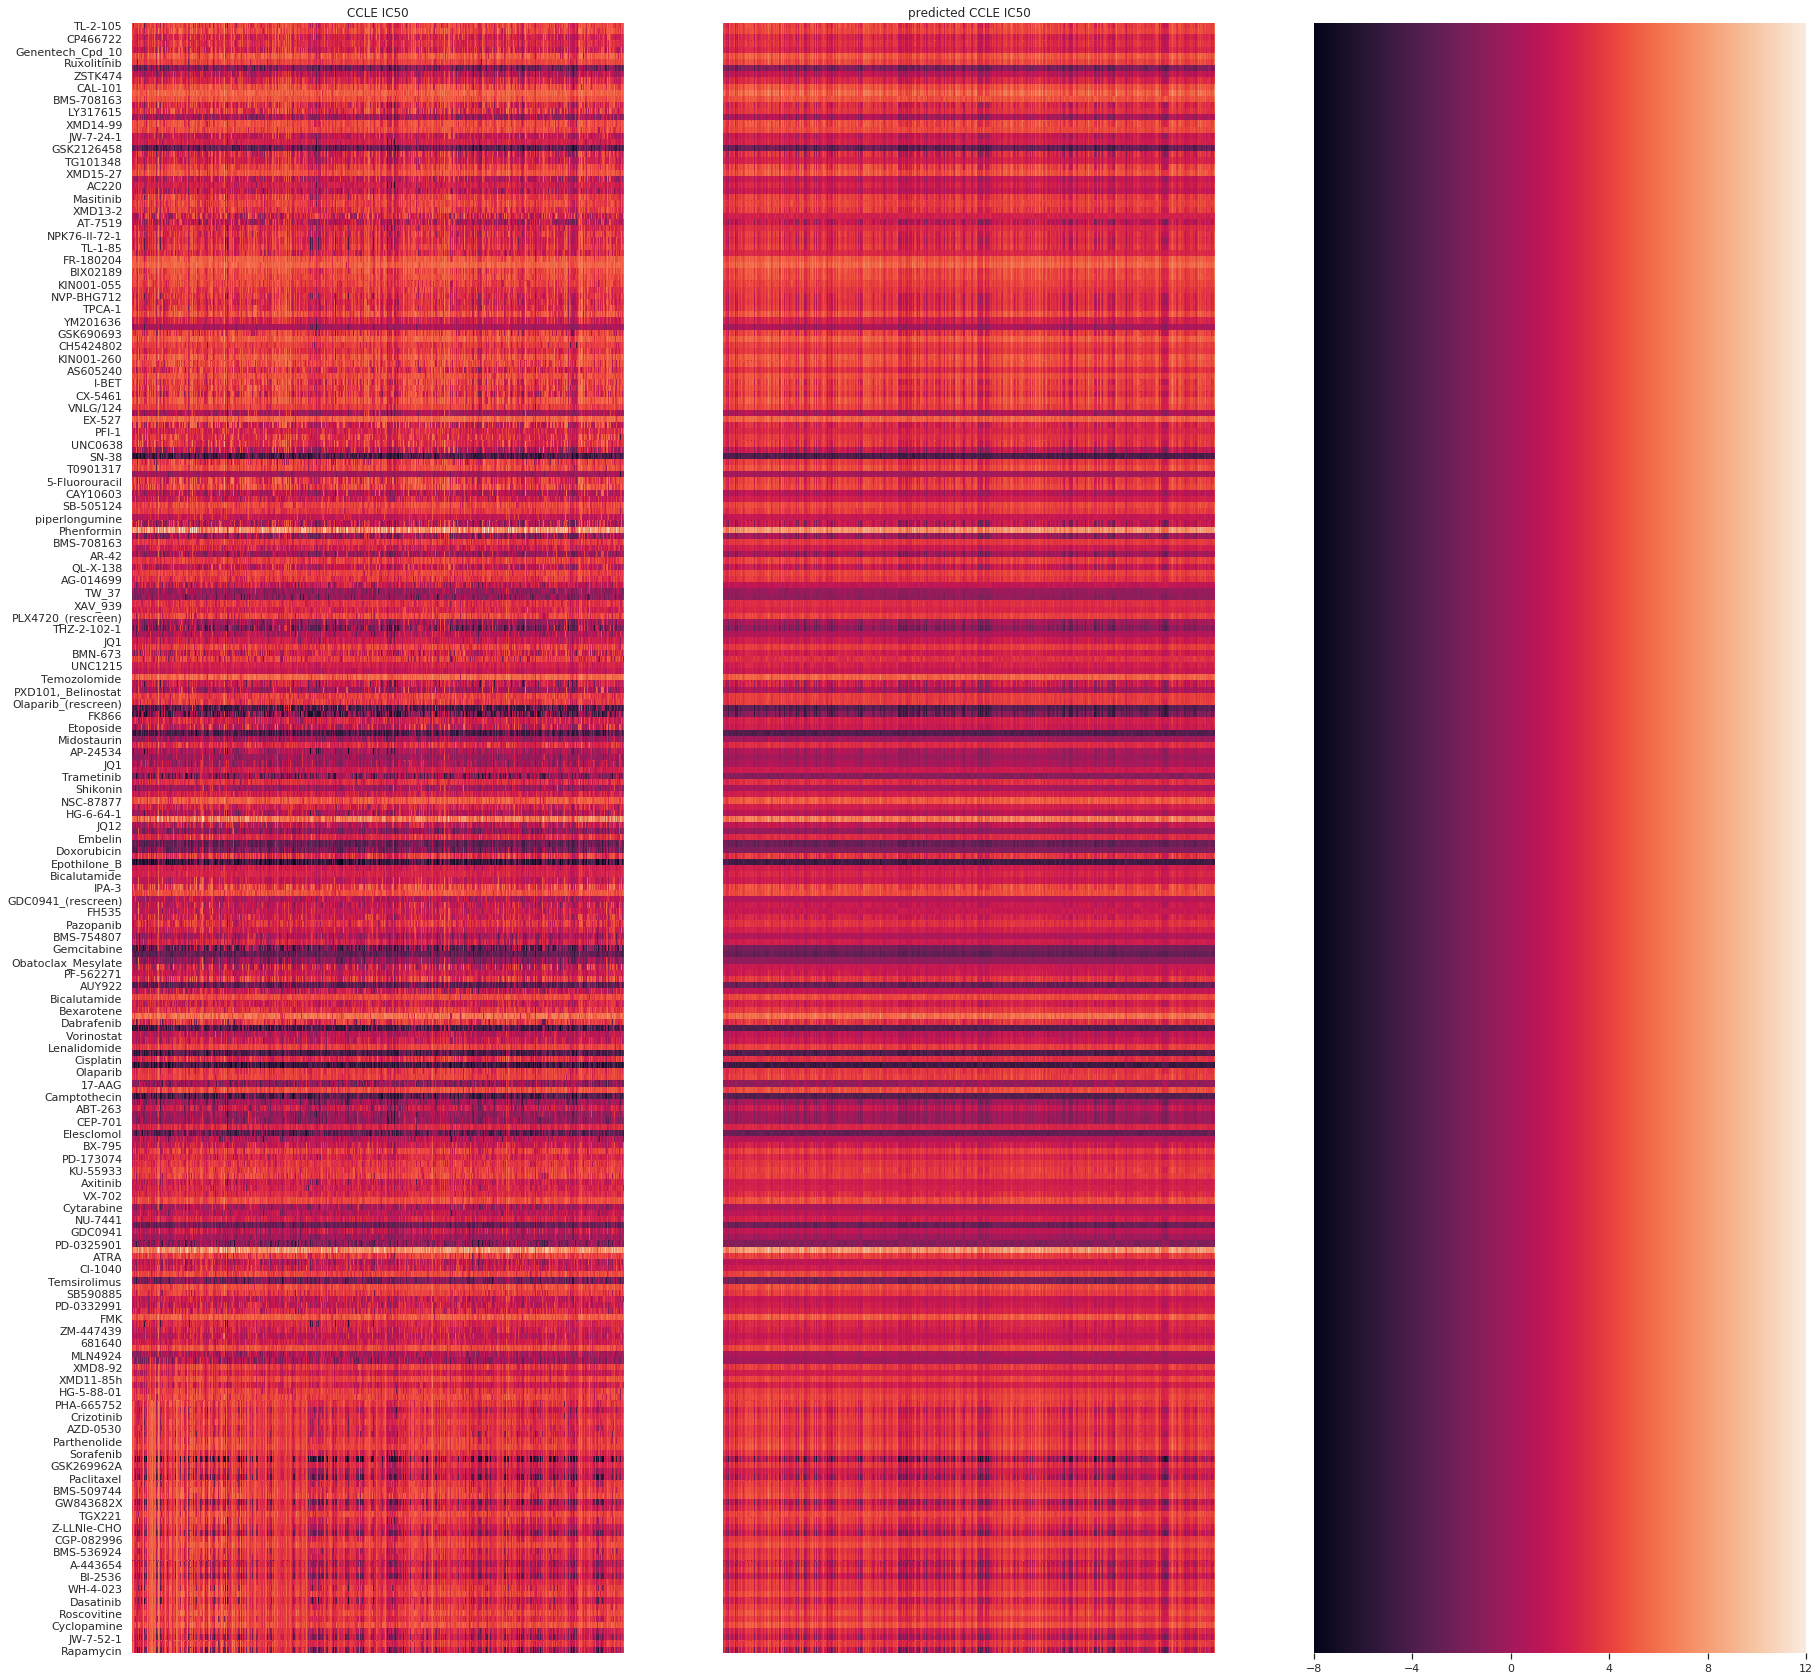

In [80]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(30,30))

sns.heatmap(y_CCLE_IC50, vmin=-8, vmax=12, ax = axs[0],cbar=False, xticklabels=False).set_title('CCLE IC50')
sns.heatmap(p_CCLE_IC50,  vmin=-8, vmax=12,  ax = axs[1],yticklabels=False, xticklabels=False, cbar_ax = axs[2],cbar_kws={"orientation": "horizontal"} ).set_title('predicted CCLE IC50')


In [74]:
p_valid = IC50_Predictor.predict([XE_valid, XM_valid])
y_valid 
p_valid.shape

(61, 265)

In [75]:
r = np.corrcoef(p_valid[2],y_valid.values[2] )
r

array([[1.       , 0.8508204],
       [0.8508204, 1.       ]])

In [76]:
s =  [np.corrcoef(i,j) for i,j in zip(p_valid,y_valid.values) ]

In [77]:
pearsonc = [i[0,1] for i in s]
len(pearsonc)
np.mean(pearsonc)

0.8758768081498898

Text(0.5,1,'Sample-wise Pearson correlation in log IC50 for CCLE validation sample')

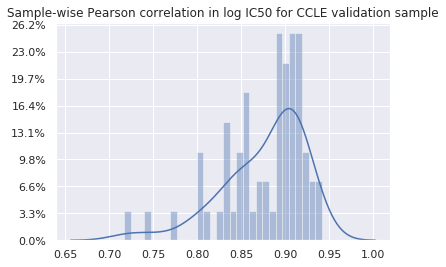

In [78]:
from matplotlib.ticker import PercentFormatter
sns.set();

ax = sns.distplot(pearsonc, bins = 30)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(pearsonc)))
ax.set_title('Sample-wise Pearson correlation in log IC50 for CCLE validation sample')

In [ ]:
# IC50 Predictor using only gene expression without mutations

In [85]:
#Complete architecture
#load pretrained E_TCGA encoder
K.clear_session()

autoencoder_E = load_model('model_encoder_E_TCGA_std_1.h5', custom_objects={'denorm_mse':denorm_mse})
autoencoder_E.name = 'au_E'


In [86]:
encoder_E  = autoencoder_E


In [87]:
for n in range(4): 
    encoder_E.layers.pop()
    
# Check the trainable status of the individual layers
#for layer in encoder:
#    print(layer, layer.trainable)

In [88]:

n_drugs = IC50.shape[1]
cell_dim = E_CCLE.shape[1]
layers = [128,128,128]

# this is our input placeholder
input1 = keras.layers.Input(shape=(cell_dim ,))
x = encoder_E(input1)

use_bn = False
for i,layer in enumerate(layers):
    l = Dense(layer, activation='relu')(x if i == 0 else l)
    if use_bn: l = BatchNormalization()(l)
out = Dense(n_drugs, activation='linear')(l)

In [89]:
IC50_Predictor = Model(inputs=input1, outputs=out)

In [90]:
IC50_Predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17947)             0         
_________________________________________________________________
au_E (Model)                 (None, 17947)             18682304  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2297344   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 265)               34185     
Total params: 21,046,857
Trainable params: 21,046,857
Non-trainable params: 0
________________________________________________________________

In [91]:
callbacks = [keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)]

adam = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IC50_Predictor.compile(optimizer= adam, loss='mean_squared_error')

In [92]:
scaler = StandardScaler()#MinMaxScaler()#DummyScaler() 
if scaler:
    scaler.fit(E_CCLE)
    E_CCLE_norm = pd.DataFrame(scaler.transform(E_CCLE), columns = E_CCLE.columns, index=E_CCLE.index)
    print (E_CCLE_norm['ALAS1'].mean(), E_CCLE_norm['ALAS1'].std())
    print(E_CCLE_norm['ALAS1'].describe())

-1.0340083581921978e-14 1.000429461046209
count    1.165000e+03
mean    -1.034008e-14
std      1.000429e+00
min     -5.767381e+00
25%     -6.566953e-01
50%     -2.205050e-02
75%      5.994854e-01
max      5.028037e+00
Name: ALAS1, dtype: float64


In [93]:
CCLE_IC50 = pd.merge(E_CCLE_norm,IC50,left_index=True, right_index=True)
CCLE_IC50.shape

(610, 18212)

In [94]:
#reserve a random sample of 20% samples to validate the model
valid = int(CCLE_IC50.shape[0]*0.1)
valid_idx = sample(list(CCLE_IC50.index.values),valid)

XE_train = E_CCLE_norm.reindex(CCLE_IC50.index.values).drop(valid_idx, axis = 0)
y_train = IC50.reindex(CCLE_IC50.index.values).drop(valid_idx, axis = 0)
XE_valid = E_CCLE_norm.loc[valid_idx, :]
y_valid = IC50.loc[valid_idx, :]


In [95]:
print(XE_train.shape)
print(y_train.shape)
print(XE_valid.shape)
print(y_valid.shape)

(549, 17947)
(549, 265)
(61, 17947)
(61, 265)


In [96]:
IC50_Predictor.fit(XE_train, y_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(XE_valid, y_valid),
                callbacks = callbacks)

Train on 549 samples, validate on 61 samples
Epoch 1/100
549/549 [==============================] - 1s 1ms/step - loss: 11.9242 - val_loss: 9.8626
Epoch 2/100
549/549 [==============================] - 0s 148us/step - loss: 9.8731 - val_loss: 7.8355
Epoch 3/100
549/549 [==============================] - 0s 144us/step - loss: 7.7045 - val_loss: 5.8370
Epoch 4/100
549/549 [==============================] - 0s 135us/step - loss: 5.5748 - val_loss: 4.3421
Epoch 5/100
549/549 [==============================] - 0s 131us/step - loss: 4.0404 - val_loss: 3.2525
Epoch 6/100
549/549 [==============================] - 0s 133us/step - loss: 3.1371 - val_loss: 2.8317
Epoch 7/100
549/549 [==============================] - 0s 130us/step - loss: 2.6014 - val_loss: 2.5549
Epoch 8/100
549/549 [==============================] - 0s 136us/step - loss: 2.3541 - val_loss: 2.3317
Epoch 9/100
549/549 [==============================] - 0s 137us/step - loss: 2.1816 - val_loss: 2.2522
Epoch 10/100
549/549 [=======

In [97]:
IC50_Predictor.save_weights('IC50_E_Predictor_weights.h5')

In [98]:
IC50_Predictor.load_weights('IC50_E_Predictor_weights.h5')

In [99]:
p = IC50_Predictor.predict(E_CCLE_norm.reindex(CCLE_IC50.index.values))
p_CCLE_IC50 = p.transpose()

In [100]:
p_CCLE_IC50.shape

(265, 610)

In [101]:
y_CCLE_IC50 = IC50.reindex(CCLE_IC50.index.values)
y_CCLE_IC50 = y_CCLE_IC50.transpose()
y_CCLE_IC50.shape

(265, 610)

Text(0.5,1,'predicted CCLE IC50')

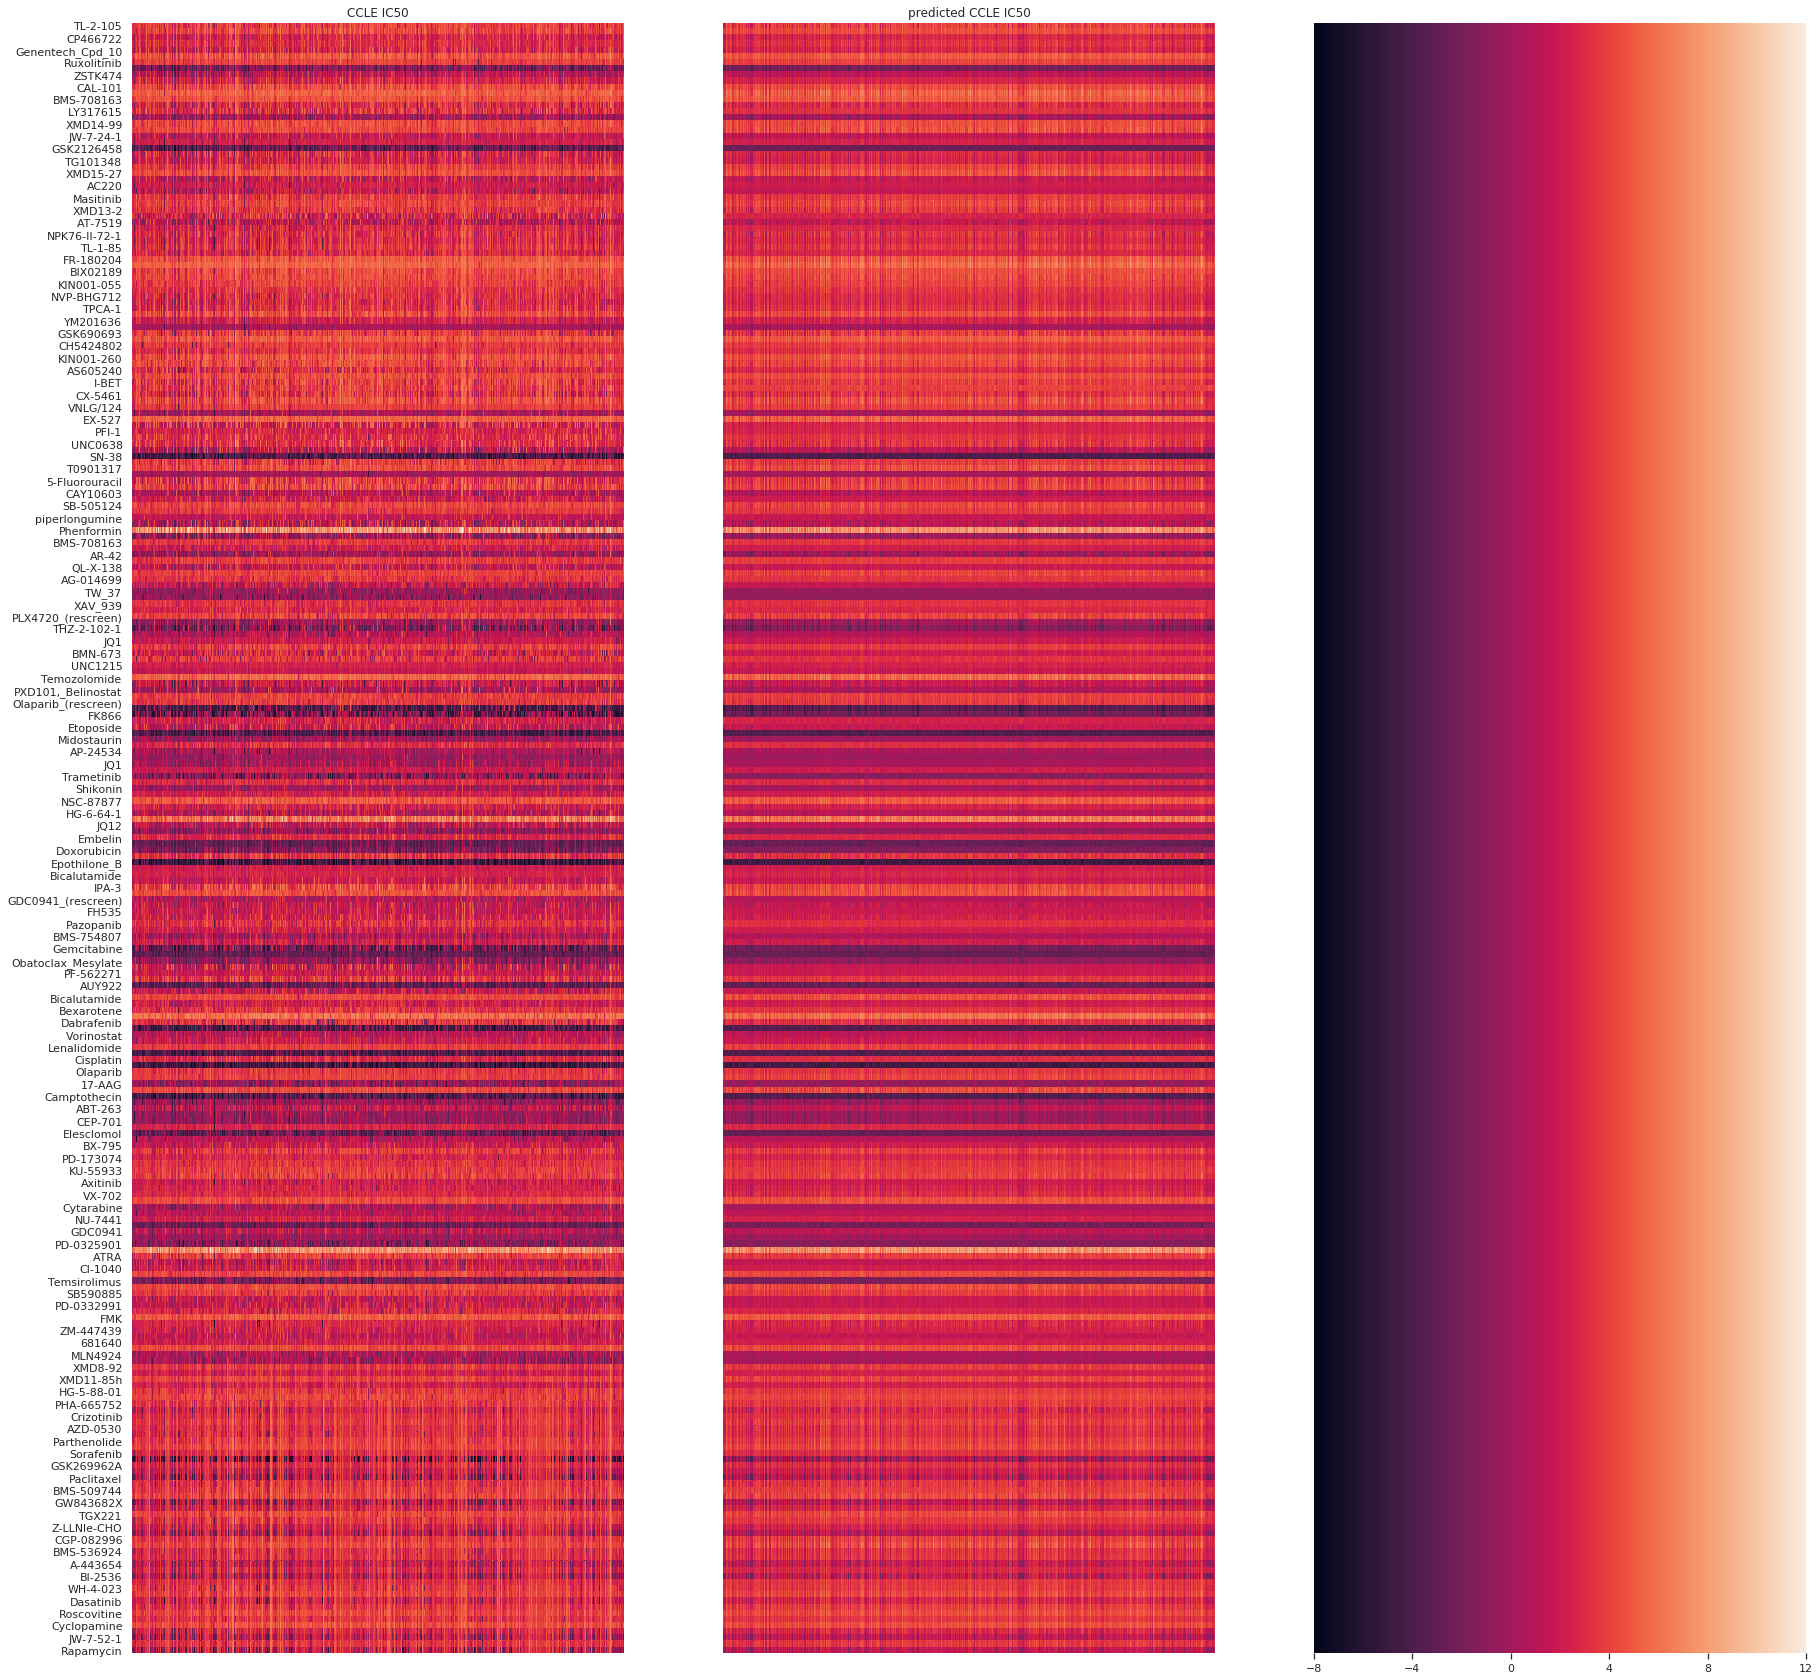

In [102]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(30,30))

sns.heatmap(y_CCLE_IC50, vmin=-8, vmax=12, ax = axs[0],cbar=False, xticklabels=False).set_title('CCLE IC50')
sns.heatmap(p_CCLE_IC50,  vmin=-8, vmax=12,  ax = axs[1],yticklabels=False, xticklabels=False, cbar_ax = axs[2],cbar_kws={"orientation": "horizontal"} ).set_title('predicted CCLE IC50')


In [104]:
p_valid = IC50_Predictor.predict(XE_valid)
y_valid 
p_valid.shape

(61, 265)

In [105]:
r = np.corrcoef(p_valid[2],y_valid.values[2] )
r

array([[1.        , 0.86588969],
       [0.86588969, 1.        ]])

In [106]:
s =  [np.corrcoef(i,j) for i,j in zip(p_valid,y_valid.values) ]

In [107]:
pearsonc = [i[0,1] for i in s]
len(pearsonc)
np.mean(pearsonc)

0.872331523747604

Text(0.5,1,'Sample-wise Pearson correlation in log IC50 for CCLE validation sample')

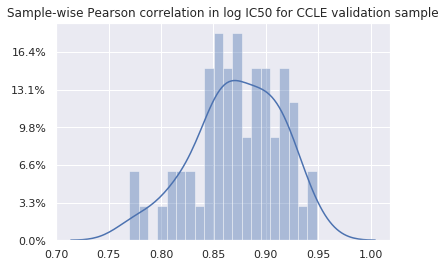

In [109]:
from matplotlib.ticker import PercentFormatter
sns.set();

ax = sns.distplot(pearsonc, bins = 20)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(pearsonc)))
ax.set_title('Sample-wise Pearson correlation in log IC50 for CCLE validation sample')